In [3]:
#Dataset from https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import sklearn
import mglearn
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from os.path import dirname, abspath

In [4]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [5]:
print(os.getcwd())

c:\Users\arant\Documents\heart_failure\eda notebooks


In [6]:
basepath2 = dirname(dirname(abspath(os.getcwd())))

In [7]:
basepath2

'c:\\Users\\arant\\Documents'

In [11]:
base_path = dirname(dirname(abspath(os.getcwd())))
data_folder = 'heart_failure'
excelfile = 'Datos.xlsx'
pathtoexcel = os.path.join(base_path,data_folder, excelfile)

In [12]:
pathtoexcel

'c:\\Users\\arant\\Documents\\heart_failure\\Datos.xlsx'

In [13]:
data = pd.read_excel(pathtoexcel)

data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,15,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0,Up,0


In [9]:
#Find variables with missing data
data.isnull().any()

#There is not missing data 

Age               False
Sex               False
ChestPainType     False
RestingBP         False
Cholesterol       False
FastingBS         False
RestingECG        False
MaxHR             False
ExerciseAngina    False
Oldpeak           False
ST_Slope          False
HeartDisease      False
dtype: bool

In [14]:
col = "HeartDisease"
heart = data.loc[:, data.columns != col]
heart.head()
heart

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40,M,ATA,140,289,0,Normal,172,N,0,Up
1,49,F,NAP,160,180,0,Normal,156,N,1,Flat
2,37,M,ATA,130,283,0,ST,98,N,0,Up
3,48,F,ASY,138,214,0,Normal,108,Y,15,Flat
4,54,M,NAP,150,195,0,Normal,122,N,0,Up
...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,12,Flat
914,68,M,ASY,144,193,1,Normal,141,N,34,Flat
915,57,M,ASY,130,131,0,Normal,115,Y,12,Flat
916,57,F,ATA,130,236,0,LVH,174,N,0,Flat


In [19]:
numeric_heart = heart.select_dtypes(include=[np.number])
print(numeric_heart)

     Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak
0     40        140          289          0    172        0
1     49        160          180          0    156        1
2     37        130          283          0     98        0
3     48        138          214          0    108       15
4     54        150          195          0    122        0
..   ...        ...          ...        ...    ...      ...
913   45        110          264          0    132       12
914   68        144          193          1    141       34
915   57        130          131          0    115       12
916   57        130          236          0    174        0
917   38        138          175          0    173        0

[918 rows x 6 columns]


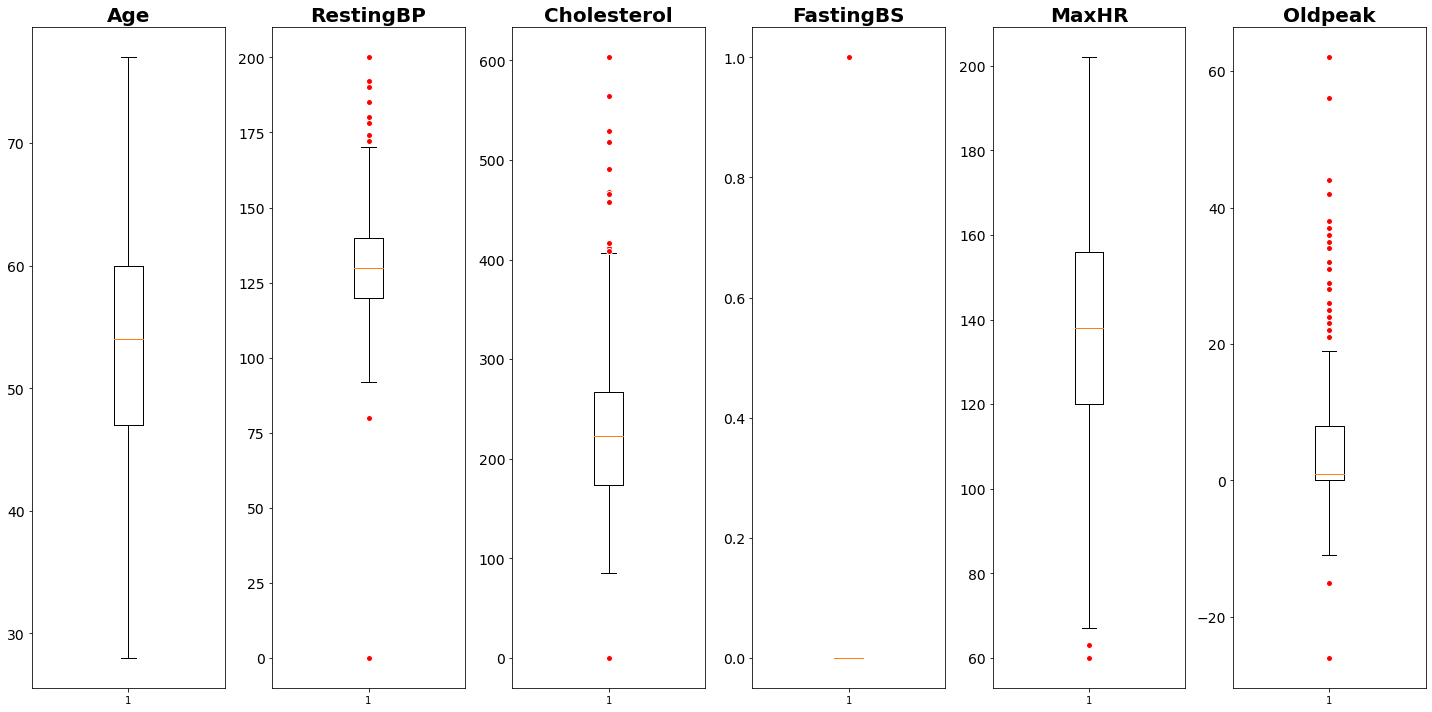

In [26]:
#Creating subplot of each column with its own scale
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

fig, axs = plt.subplots(1, len(numeric_heart.columns), figsize=(20,10))

for i, ax in enumerate(axs.flat):
    ax.boxplot(numeric_heart.iloc[:,i], flierprops=red_circle)
    ax.set_title(numeric_heart.columns[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
    
plt.tight_layout()

In [ ]:
#Make a for loop for this boxplot

numeric_heart['Age'].plot(kind='box')

In [31]:
corr = numeric_heart.corr()
corr.style.background_gradient(cmap='coolwarm')

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
Age,1.000000,0.254399,-0.095282,0.198039,-0.382045,0.227478
RestingBP,0.254399,1.000000,0.100893,0.070193,-0.112135,0.091745
Cholesterol,-0.095282,0.100893,1.000000,-0.260974,0.235792,0.028366
FastingBS,0.198039,0.070193,-0.260974,1.000000,-0.131438,0.058124
MaxHR,-0.382045,-0.112135,0.235792,-0.131438,1.000000,-0.079022
Oldpeak,0.227478,0.091745,0.028366,0.058124,-0.079022,1.000000


In [30]:
categorical_heart = heart.select_dtypes(exclude=[np.number])
print(categorical_heart)

    Sex ChestPainType RestingECG ExerciseAngina ST_Slope
0     M           ATA     Normal              N       Up
1     F           NAP     Normal              N     Flat
2     M           ATA         ST              N       Up
3     F           ASY     Normal              Y     Flat
4     M           NAP     Normal              N       Up
..   ..           ...        ...            ...      ...
913   M            TA     Normal              N     Flat
914   M           ASY     Normal              N     Flat
915   M           ASY     Normal              Y     Flat
916   F           ATA        LVH              N     Flat
917   M           NAP     Normal              N       Up

[918 rows x 5 columns]


In [34]:
for col in categorical_heart:
            print(col)

Sex
ChestPainType
RestingECG
ExerciseAngina
ST_Slope


In [ ]:
corr = numeric_heart.corr()
corr.style.background_gradient(cmap='coolwarm')

<AxesSubplot:>

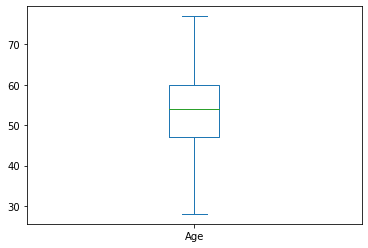

In [23]:
numeric_heart['Age'].plot(kind='box')

In [11]:
#Difference between One Hot Encoder and pandas get dummies. 
cat_encoder = OneHotEncoder()
sex_cat = heart[["Sex"]]
sex_1hot = cat_encoder.fit_transform(sex_cat)
sex_1hot
cat_encoder.categories_
sexarray = sex_1hot.toarray()

In [12]:
heart_encoded = pd.get_dummies(heart, columns = ['Sex', 'ChestPainType','RestingECG',
                                                            'ExerciseAngina', 'ST_Slope'])

heart_encoded


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1
1,49,160,180,0,156,1,1,0,0,0,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0,0,1,0,1,0,0,0,0,1,1,0,0,0,1
3,48,138,214,0,108,15,1,0,1,0,0,0,0,1,0,0,1,0,1,0
4,54,150,195,0,122,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,110,264,0,132,12,0,1,0,0,0,1,0,1,0,1,0,0,1,0
914,68,144,193,1,141,34,0,1,1,0,0,0,0,1,0,1,0,0,1,0
915,57,130,131,0,115,12,0,1,1,0,0,0,0,1,0,0,1,0,1,0
916,57,130,236,0,174,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0


In [13]:
target = data["HeartDisease"]
target.head()

0    0
1    1
2    0
3    1
4    0
Name: HeartDisease, dtype: int64

In [14]:
#Number of class I have 
data['HeartDisease'].value_counts()

#Class type 0-> 410  Not heart failure 
#Class type 1-> 508  Heart failure 

1    508
0    410
Name: HeartDisease, dtype: int64

In [15]:
#Separate categorical and numerical variables that needs to be transformed

numeric_heart = heart.select_dtypes(include=[np.number])
categorical_heart = heart.select_dtypes(exclude=[np.number])

numeric_heart.shape[1]
categorical_heart.shape[1]

#5 columns categoricas y #6 columns numerics 

print(numeric_heart)
#print(categorical_heart)

     Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak
0     40        140          289          0    172        0
1     49        160          180          0    156        1
2     37        130          283          0     98        0
3     48        138          214          0    108       15
4     54        150          195          0    122        0
..   ...        ...          ...        ...    ...      ...
913   45        110          264          0    132       12
914   68        144          193          1    141       34
915   57        130          131          0    115       12
916   57        130          236          0    174        0
917   38        138          175          0    173        0

[918 rows x 6 columns]


In [16]:
#from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()
#scaler.fit(numeric_heart)

# transform data
#numeric_heart_scaled = scaler.transform(numeric_heart)
# print dataset properties before and after scaling


#print("transformed shape: {}".format(numeric_heart_scaled.shape))
#print("per-feature minimum before scaling:\n {}".format(numeric_heart.min(axis=0)))
#print("per-feature maximum before scaling:\n {}".format(numeric_heart.max(axis=0)))
#print("per-feature minimum after scaling:\n {}".format(
#numeric_heart_scaled.min(axis=0)))
#print("per-feature maximum after scaling:\n {}".format(
#numeric_heart_scaled.max(axis=0)))


In [17]:
#print(numeric_heart_scaled)

In [18]:
#Normalize data for develop NN 
num_pipeline = Pipeline([
               ('scaler', MinMaxScaler()),
    ])

#Delete outliers


In [19]:
#Transformer requires Index type, so this would be the proper way to do it

categorical_features = heart.select_dtypes(include="object").columns
integer_features = heart.select_dtypes(exclude="object").columns

In [20]:
from sklearn.compose import ColumnTransformer
num_attribs = integer_features
cat_attribs = categorical_features
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

heart_prepared = full_pipeline.fit_transform(heart)

In [21]:
names = get_feature_names(full_pipeline)

C:\Users\arant\AppData\Local\Temp\ipykernel_22312\1809191144.py:30: UserWarning: Transformer scaler (type MinMaxScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
c:\Users\arant\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [22]:
print(names)

['num__Age', 'num__RestingBP', 'num__Cholesterol', 'num__FastingBS', 'num__MaxHR', 'num__Oldpeak', 'cat__x0_F', 'cat__x0_M', 'cat__x1_ASY', 'cat__x1_ATA', 'cat__x1_NAP', 'cat__x1_TA', 'cat__x2_LVH', 'cat__x2_Normal', 'cat__x2_ST', 'cat__x3_N', 'cat__x3_Y', 'cat__x4_Down', 'cat__x4_Flat', 'cat__x4_Up']


In [23]:
#Create a dataframe with their columns name 

features = pd.DataFrame(heart_prepared,columns=names)
print(features)

     num__Age  num__RestingBP  num__Cholesterol  num__FastingBS  num__MaxHR  \
0    0.244898            0.70          0.479270             0.0    0.788732   
1    0.428571            0.80          0.298507             0.0    0.676056   
2    0.183673            0.65          0.469320             0.0    0.267606   
3    0.408163            0.69          0.354892             0.0    0.338028   
4    0.530612            0.75          0.323383             0.0    0.436620   
..        ...             ...               ...             ...         ...   
913  0.346939            0.55          0.437811             0.0    0.507042   
914  0.816327            0.72          0.320066             1.0    0.570423   
915  0.591837            0.65          0.217247             0.0    0.387324   
916  0.591837            0.65          0.391376             0.0    0.802817   
917  0.204082            0.69          0.290216             0.0    0.795775   

     num__Oldpeak  cat__x0_F  cat__x0_M  cat__x1_AS

In [24]:
dataset = features.values

In [25]:
x = features
y = target

In [26]:
#Balance for test and training set 

#Random state
#Controls the shuffling applied to the data before applying the split. 
#Pass an int for reproducible output across multiple function calls.

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=100)
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

#Now dataset is balanced 

#Training target statistics: Counter({1: 403, 0: 331})
#Testing target statistics: Counter({1: 105, 0: 79})

Training target statistics: Counter({1: 403, 0: 331})
Testing target statistics: Counter({1: 105, 0: 79})


In [27]:
x_train.columns
len(x_train.columns)

20

In [28]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential([
    Dense(32, activation='relu', input_shape=(len(x_train.columns),)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid'),
])

In [29]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [30]:
hist = model.fit(x_train, y_train,
          batch_size=32, epochs=100,
          validation_data=(x_test, y_test))

Epoch 1/100
23/23 [==============================] - 1s 11ms/step - loss: 0.6756 - accuracy: 0.5463 - val_loss: 0.6614 - val_accuracy: 0.5707
Epoch 2/100
23/23 [==============================] - 0s 2ms/step - loss: 0.6564 - accuracy: 0.5490 - val_loss: 0.6441 - val_accuracy: 0.5815
Epoch 3/100
23/23 [==============================] - 0s 2ms/step - loss: 0.6381 - accuracy: 0.6076 - val_loss: 0.6271 - val_accuracy: 0.6359
Epoch 4/100
23/23 [==============================] - 0s 2ms/step - loss: 0.6202 - accuracy: 0.6744 - val_loss: 0.6104 - val_accuracy: 0.7228
Epoch 5/100
23/23 [==============================] - 0s 2ms/step - loss: 0.6021 - accuracy: 0.7221 - val_loss: 0.5937 - val_accuracy: 0.7717
Epoch 6/100
23/23 [==============================] - 0s 2ms/step - loss: 0.5840 - accuracy: 0.7616 - val_loss: 0.5769 - val_accuracy: 0.7826
Epoch 7/100
23/23 [==============================] - 0s 2ms/step - loss: 0.5656 - accuracy: 0.7684 - val_loss: 0.5602 - val_accuracy: 0.7772
Epoch 8/100
